In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from pprint import pprint

sns.set(style="whitegrid")

from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
from sklearn.model_selection import train_test_split

from sklearn import metrics 
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import xgboost as xgb
from sklearn import tree

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', None)

In [45]:
#Read in a bunch of csv files and stack them together

path =r'C:\\Users\\armcl\\Python\\Lending Club\\Data' 
all_files = glob.glob(os.path.join(path, "*.csv"))     
df_from_each_file = (pd.read_csv(f,skiprows=[0],header=0,low_memory=False) for f in all_files)
lc_all   = pd.concat(df_from_each_file, ignore_index=True)

In [46]:
#Remove all NAs data
lc_all.dropna(subset=['loan_status'], inplace=True)

#int rate to numeric
lc_all['int_rate'] = pd.to_numeric(lc_all['int_rate'].str.replace("%", "").str.replace(" ", ""))

#Extract the initiation year feature
lc_all['issue_d'] = pd.to_datetime(lc_all['issue_d'])
lc_all['last_pymnt_d'] = pd.to_datetime(lc_all['last_pymnt_d'])
lc_all['issue_y'] = lc_all['issue_d'].dt.year

#Defaulted loans are tiny and let's relabel them to charge off
lc_all['loan_status'].replace({'Default':'Charged Off'}, inplace=True)

In [47]:
#Current loans are not necessarily going to be fully paid
#Only include loans that are charged off in this analysis

charged_off = lc_all.loc[lc_all['loan_status'].isin(['Charged Off']),:]

In [48]:
#Calculate the recovery rate given the loan is charged off
#LGD = total payments (including recoveries) / total amount of principal + interests
#Time value of money is not considered here

charged_off['term_num'] = charged_off['term'].replace({' 36 months':36,' 60 months':60})
charged_off['total_loan'] = charged_off['term_num'] * charged_off['installment']
charged_off['recovery_rate'] = charged_off['total_pymnt_inv'] / charged_off['total_loan']

#A small number of calculations were slightly above 1 and they were converted to 1
charged_off.loc[charged_off['recovery_rate']>1,'recovery_rate']=1
charged_off['LGD'] = 1 - charged_off['recovery_rate']

charged_off['LGD'].quantile([0,.01, .1, .25, 1/3, .5, 2/3, .75, .9, .99,1])

C:\Users\armcl\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\armcl\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\armcl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

0.000000    0.000000
0.010000    0.052381
0.100000    0.245520
0.250000    0.414938
0.333333    0.487416
0.500000    0.609612
0.666667    0.710533
0.750000    0.757023
0.900000    0.851077
0.990000    0.968064
1.000000    1.000000
Name: LGD, dtype: float64

In [49]:
print("Mean LGD: ", charged_off['LGD'].mean())
print("Stdev LGD: ", charged_off['LGD'].std())

Mean LGD:  0.5767545968947361
Stdev LGD:  0.22688273864386777


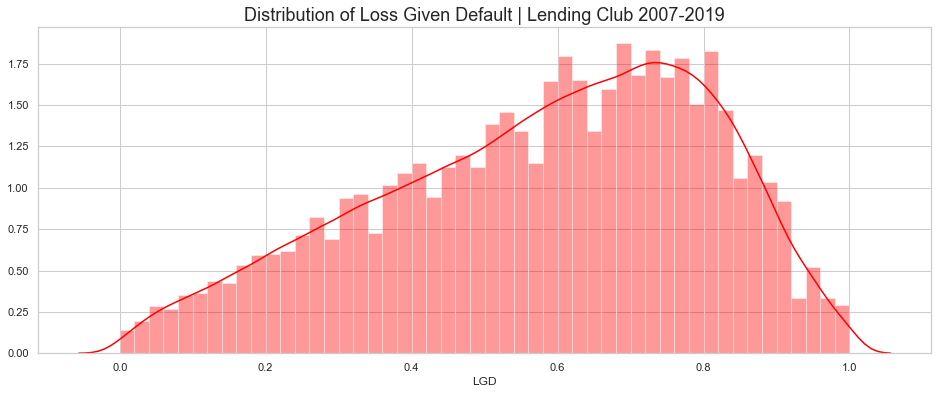

In [50]:
#Plot the distribution of LGD

plt.figure(figsize=(16, 6))
ax = sns.distplot(charged_off['LGD'],color='red')
ax.set_title("Distribution of Loss Given Default | Lending Club 2007-2019", fontsize=18)
plt.show()

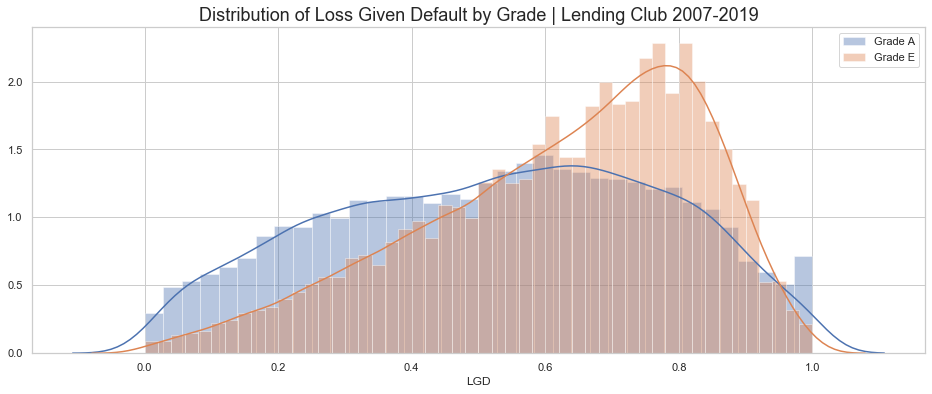

In [51]:
#Plot the distribution of LGD

plt.figure(figsize=(16, 6))
ax = sns.distplot(charged_off.loc[charged_off['grade']=='A','LGD'],label='Grade A')
ax = sns.distplot(charged_off.loc[charged_off['grade']=='E','LGD'],label='Grade E')

ax.set_title("Distribution of Loss Given Default by Grade | Lending Club 2007-2019", fontsize=18)
plt.legend()
plt.show()

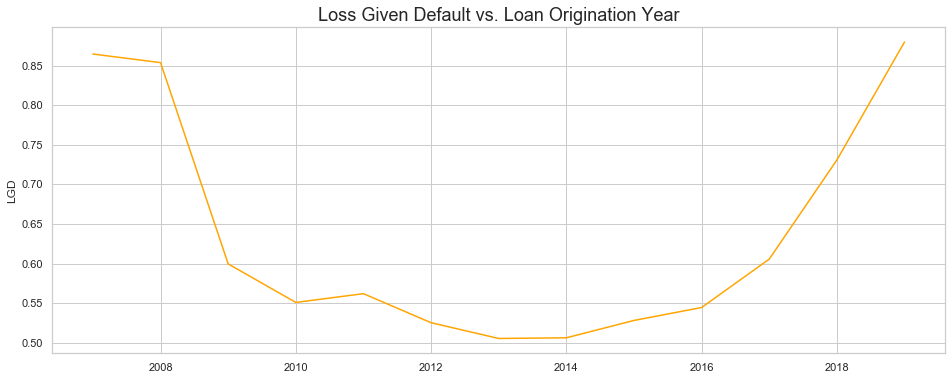

In [52]:
#Default Rate by issue year
#The peak during 2007-2008 is due to the financial crisis
#The peak after 2016 is probably because Lending Club loosens their credit standard to boost growth

LGD_by_issue_y = charged_off.groupby('issue_y').mean()

plt.figure(figsize=(16, 6))
ax = sns.lineplot(x=LGD_by_issue_y.index, y="LGD", data=LGD_by_issue_y, color='orange')

#plt.xticks(agg_logins_mean.index, rotation=45)
ax.set_xlabel('')
ax.set_title("Loss Given Default vs. Loan Origination Year", fontsize=18)
plt.show()

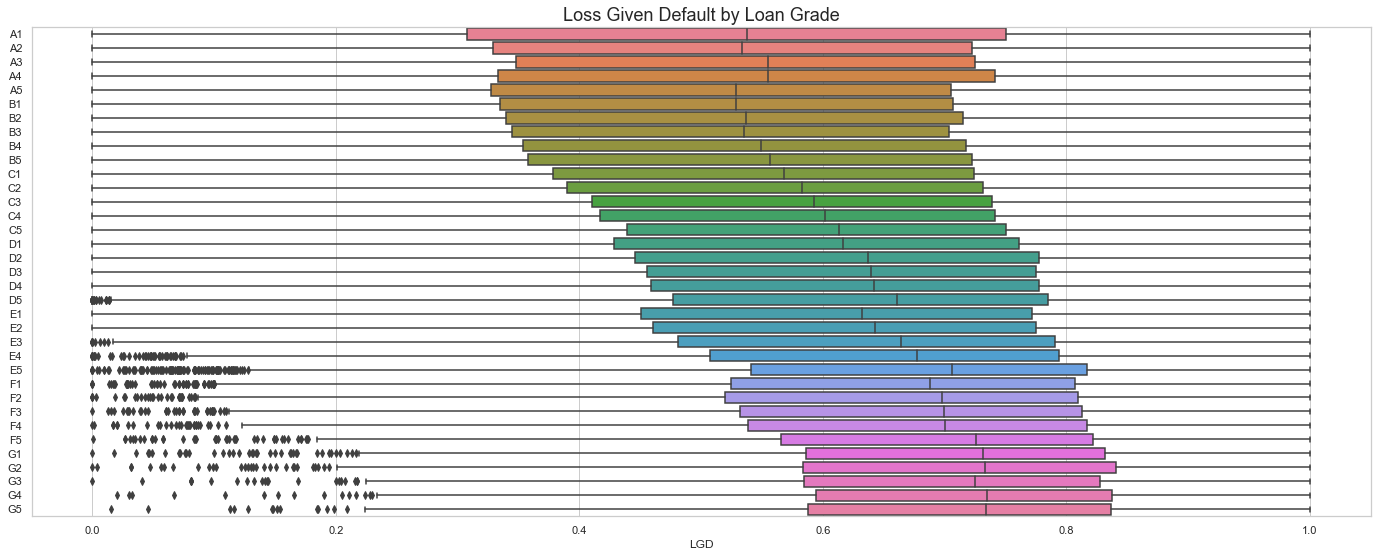

In [53]:
#LGD by subgroup

plt.figure(figsize=(24, 9))
ax = sns.boxplot(x="LGD", y='sub_grade', orient="h", palette = 'husl', data=charged_off.sort_values('sub_grade'))
ax.set_title("Loss Given Default by Loan Grade", fontsize=18)
ax.set_ylabel('')

plt.show()

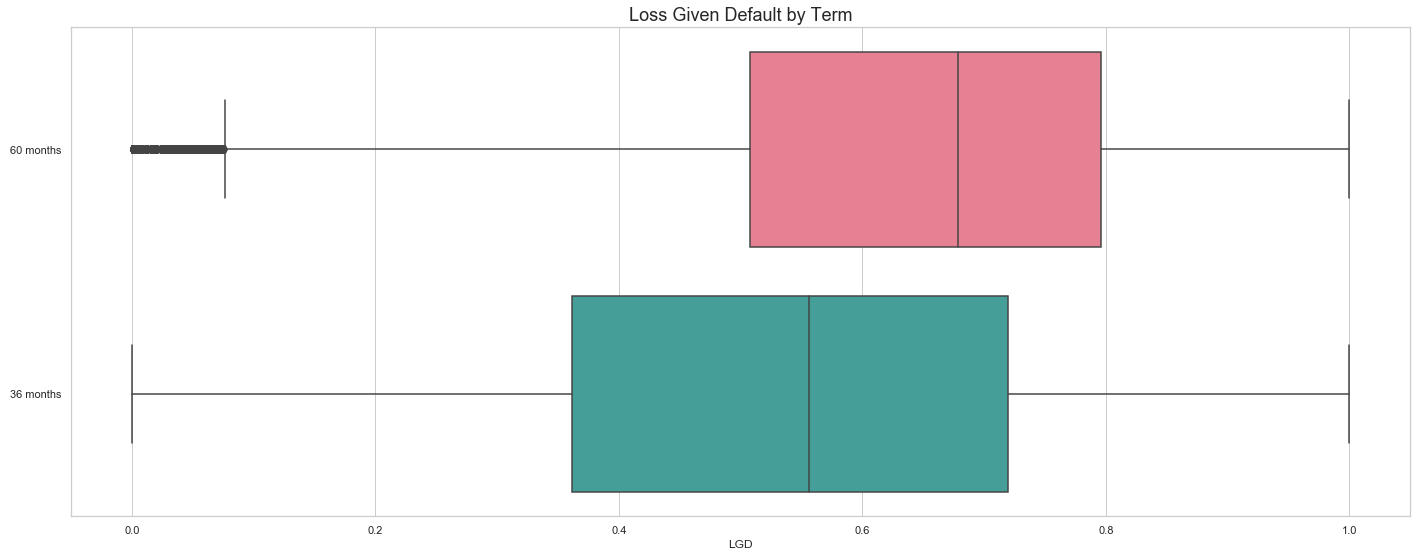

In [54]:
#LGD by term

plt.figure(figsize=(24, 9))
ax = sns.boxplot(x="LGD", y='term', orient="h", palette = 'husl', data=charged_off)
ax.set_title("Loss Given Default by Term", fontsize=18)
ax.set_ylabel('')

plt.show()

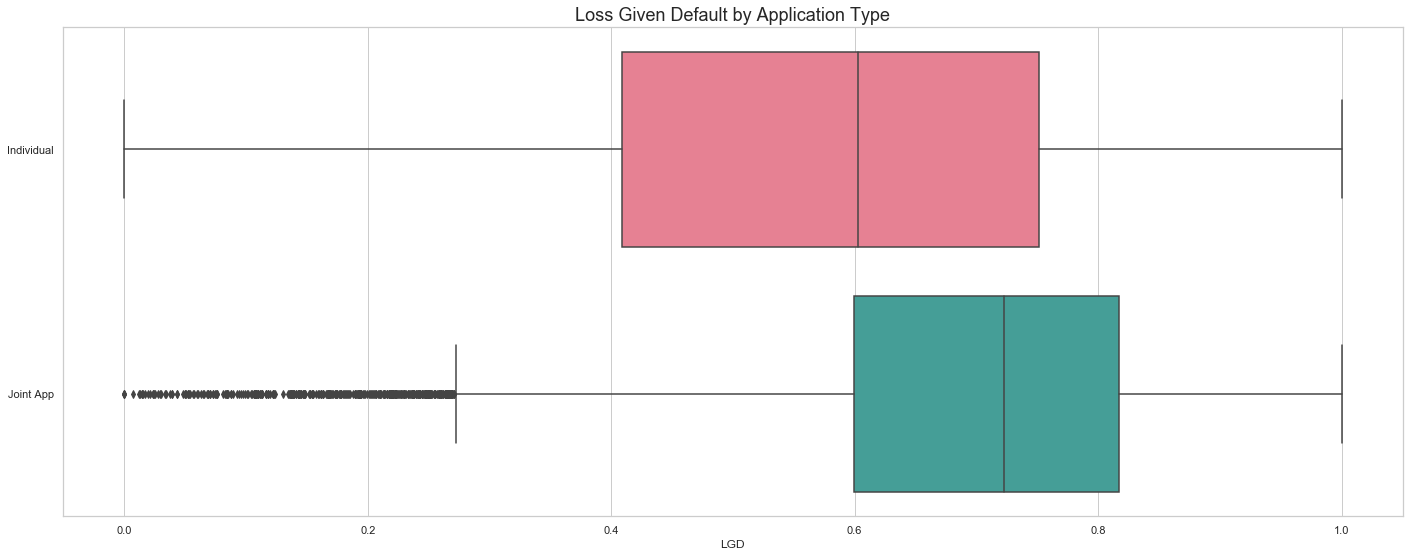

In [55]:
#LGD by application type

plt.figure(figsize=(24, 9))
ax = sns.boxplot(x="LGD", y='application_type', orient="h", palette = 'husl', data=charged_off.sort_values('application_type'))
ax.set_title("Loss Given Default by Application Type", fontsize=18)
ax.set_ylabel('')

plt.show()

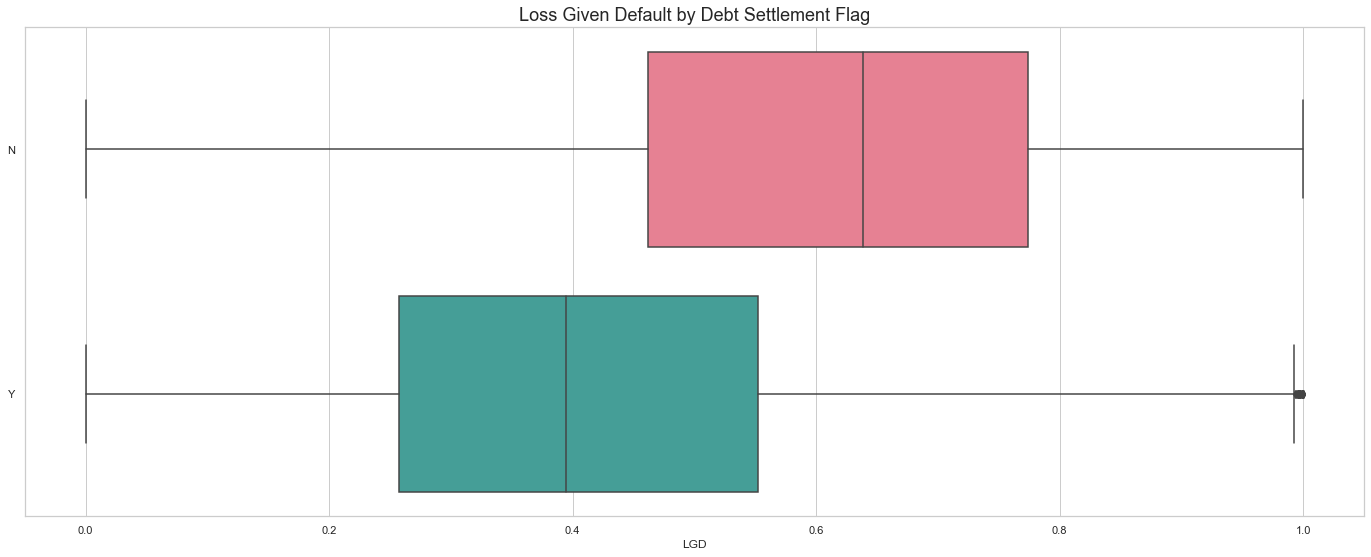

In [56]:
#LGD by debt settlement flag
#If works with a debt settlement company, the LGD is lower
#Note that this is not known beforewards

plt.figure(figsize=(24, 9))
ax = sns.boxplot(x="LGD", y='debt_settlement_flag', orient="h", palette = 'husl', data=charged_off.sort_values('debt_settlement_flag'))
ax.set_title("Loss Given Default by Debt Settlement Flag", fontsize=18)
ax.set_ylabel('')

plt.show()

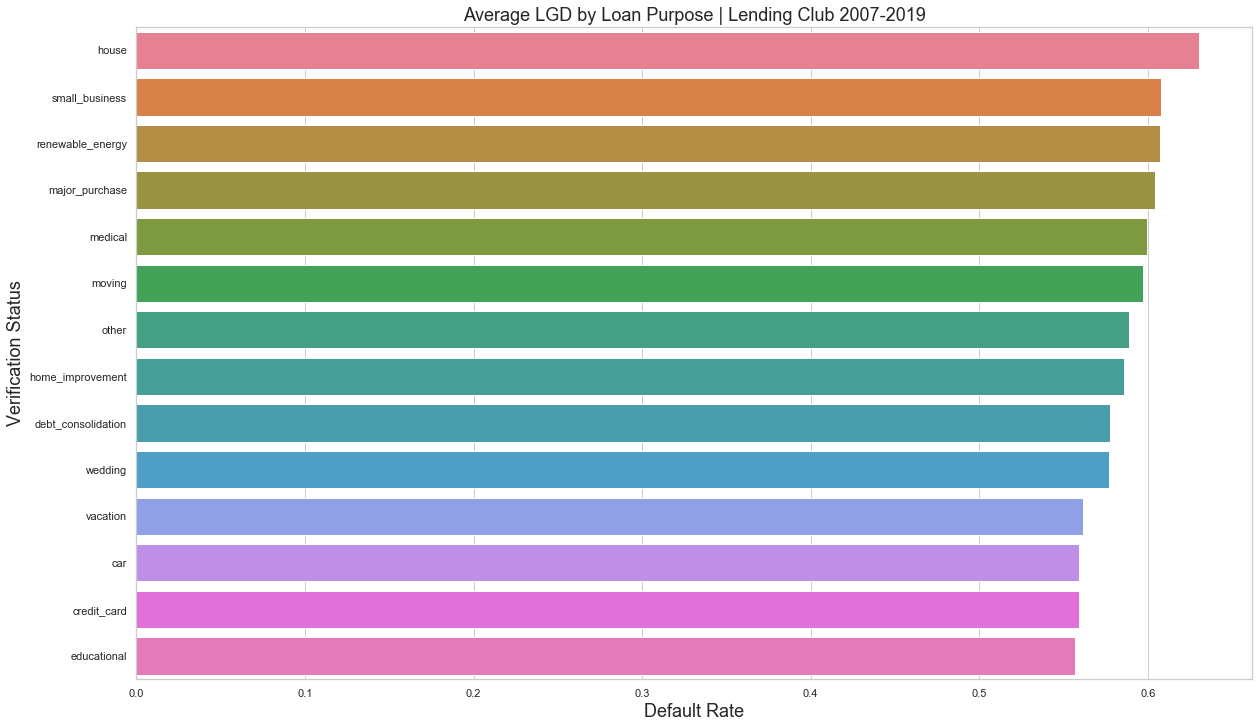

In [57]:
#Avg LGD by purpose

loan_status_by_purpose = charged_off.groupby('purpose').mean().sort_values('LGD',ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=loan_status_by_purpose['LGD'], y=loan_status_by_purpose.index, palette = 'husl')

# Add labels to your graph
plt.xlabel('Default Rate', fontsize=18)
plt.ylabel('Verification Status', fontsize=18)
plt.title("Average LGD by Loan Purpose | Lending Club 2007-2019", fontsize=18)
plt.show()

In [58]:
#Avoid data leakage (remove features that were unknown at the time of the loan initiaion)
leakage_features = ['collection_recovery_fee','last_credit_pull_d','last_fico_range_high',
                    'last_fico_range_low','last_pymnt_amnt','last_pymnt_d','next_pymnt_d',
                    'num_tl_120dpd_2m','num_tl_30dpd','out_prncp','out_prncp_inv',
                    'recoveries','total_pymnt','total_pymnt_inv','total_rec_int',
                    'total_rec_late_fee','total_rec_prncp','debt_settlement_flag',
                    'debt_settlement_flag_date','settlement_status','settlement_date',
                    'settlement_amount','settlement_percentage','settlement_term']

#Remove features that don't have much added information
#For example sub_grade is finer than grade
features_to_remove = leakage_features + ['emp_title','loan_amnt','funded_amnt_inv','grade',
                                         'id','member_id','title','url','zip_code',
                                         'pymnt_plan','policy_code']

charged_off = charged_off.drop(columns=features_to_remove)


In [59]:
#If join application, replace with the joint info

charged_off['revol_util'] = pd.to_numeric(charged_off['revol_util'].str.replace("%", ""))

charged_off.loc[charged_off['application_type']=='Joint App','annual_inc'] = charged_off.loc[charged_off['application_type']=='Joint App','annual_inc_joint']
charged_off.loc[charged_off['application_type']=='Joint App','dti'] = charged_off.loc[charged_off['application_type']=='Joint App','dti_joint']
charged_off.loc[charged_off['application_type']=='Joint App','verification_status'] = charged_off.loc[charged_off['application_type']=='Joint App','verification_status_joint']

charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['revol_bal_joint'].isnull()),'revol_bal'] = charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['revol_bal_joint'].isnull()),'revol_bal_joint']
charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_fico_range_low'].isnull()),'fico_range_low'] = (charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_fico_range_low'].isnull()),'fico_range_low'] + charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_fico_range_low'].isnull()),'sec_app_fico_range_low'])/2
charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_fico_range_high'].isnull()),'fico_range_high'] = (charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_fico_range_high'].isnull()),'fico_range_high'] + charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_fico_range_high'].isnull()),'sec_app_fico_range_high'])/2
charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_inq_last_6mths'].isnull()),'inq_last_6mths'] = (charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_inq_last_6mths'].isnull()),'inq_last_6mths'] + charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_inq_last_6mths'].isnull()),'sec_app_inq_last_6mths'])/2
charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_mort_acc'].isnull()),'mort_acc'] = (charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_mort_acc'].isnull()),'mort_acc'] + charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_mort_acc'].isnull()),'sec_app_mort_acc'])/2
charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_open_acc'].isnull()),'open_acc'] = (charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_open_acc'].isnull()),'open_acc'] + charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_open_acc'].isnull()),'sec_app_open_acc'])/2
charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_revol_util'].isnull()),'revol_util'] = (charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_revol_util'].isnull()),'revol_util'] + charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_revol_util'].isnull()),'sec_app_revol_util'])/2
charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_open_act_il'].isnull()),'open_act_il'] = (charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_open_act_il'].isnull()),'open_act_il'] + charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_open_act_il'].isnull()),'sec_app_open_act_il'])/2
charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_num_rev_accts'].isnull()),'num_rev_accts'] = (charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_num_rev_accts'].isnull()),'num_rev_accts'] + charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_num_rev_accts'].isnull()),'sec_app_num_rev_accts'])/2
charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_chargeoff_within_12_mths'].isnull()),'chargeoff_within_12_mths'] = (charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_chargeoff_within_12_mths'].isnull()),'chargeoff_within_12_mths'] + charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_chargeoff_within_12_mths'].isnull()),'sec_app_chargeoff_within_12_mths'])/2
charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_collections_12_mths_ex_med'].isnull()),'collections_12_mths_ex_med'] = (charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_collections_12_mths_ex_med'].isnull()),'collections_12_mths_ex_med'] + charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_collections_12_mths_ex_med'].isnull()),'sec_app_collections_12_mths_ex_med'])/2
charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_mths_since_last_major_derog'].isnull()),'mths_since_last_major_derog'] = (charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_mths_since_last_major_derog'].isnull()),'mths_since_last_major_derog'] + charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_mths_since_last_major_derog'].isnull()),'sec_app_mths_since_last_major_derog'])/2

In [60]:
#Reduce the number of categories for home ownership
charged_off = charged_off.replace({'home_ownership' : {'ANY':'OTHER','NONE':'OTHER'}})

#Create dummy variables

charged_off = pd.concat([charged_off, charged_off['term'].str.get_dummies(sep=',')], axis=1)
charged_off = pd.concat([charged_off, charged_off['sub_grade'].str.get_dummies(sep=',')], axis=1)
charged_off = pd.concat([charged_off, pd.get_dummies(charged_off['home_ownership'],prefix="Home")], axis=1)
charged_off = pd.concat([charged_off, charged_off['verification_status'].str.get_dummies(sep=',')], axis=1)
charged_off = pd.concat([charged_off, pd.get_dummies(charged_off['purpose'],prefix="purpose")], axis=1)
charged_off = pd.concat([charged_off, charged_off['addr_state'].str.get_dummies(sep=',')], axis=1)
charged_off = pd.concat([charged_off, pd.get_dummies(charged_off['initial_list_status'],prefix="list_status")], axis=1)
charged_off = pd.concat([charged_off, charged_off['application_type'].str.get_dummies(sep=',')], axis=1)
charged_off = pd.concat([charged_off, charged_off['loan_status'].str.get_dummies(sep=',')], axis=1)

In [61]:
#Replace categorical variables to numerical
charged_off = charged_off.replace({'emp_length' : {'< 1 year':0.5,'1 year':1,'2 years':2,'3 years':3,'4 years':4,'5 years':5,'6 years':6,'7 years':7,'8 years':8,'9 years':9,'10+ years':15}})

#Create a few new features

charged_off['loan_desc_length'] = charged_off['desc'].str.len().fillna(0)

charged_off['earliest_cr_line'] = pd.to_datetime(charged_off['earliest_cr_line'])
charged_off['cr_line_months'] = charged_off['issue_d'] - charged_off['earliest_cr_line']
charged_off['cr_line_months']=round(charged_off['cr_line_months']/np.timedelta64(1,'M'),2)

charged_off['sec_app_earliest_cr_line'] = pd.to_datetime(charged_off['sec_app_earliest_cr_line'])
charged_off['sec_app_cr_line_months'] = charged_off['issue_d'] - charged_off['sec_app_earliest_cr_line']
charged_off['sec_app_cr_line_months']=round(charged_off['sec_app_cr_line_months']/np.timedelta64(1,'M'),2)

charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_cr_line_months'].isnull()),'cr_line_months'] = (charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_cr_line_months'].isnull()),'cr_line_months'] + charged_off.loc[(charged_off['application_type']=='Joint App')&(~charged_off['sec_app_cr_line_months'].isnull()),'sec_app_cr_line_months'])/2

charged_off['fico_range_avg'] = (charged_off['fico_range_low'] + charged_off['fico_range_high'])/2

#And remove the joint data
features_to_remove = ['annual_inc_joint','dti_joint','verification_status_joint','revol_bal_joint','sec_app_fico_range_low','sec_app_fico_range_high','sec_app_inq_last_6mths',
                      'sec_app_mort_acc','sec_app_open_acc','sec_app_revol_util','sec_app_open_act_il','sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med',
                      'sec_app_mths_since_last_major_derog','sec_app_cr_line_months',
                      'sec_app_earliest_cr_line']

charged_off = charged_off.drop(columns=features_to_remove)


In [62]:
#Fill Nas
#For these features, the longer the better

features_to_inverse = ['mths_since_last_delinq','mths_since_last_record','mths_since_last_major_derog',
              'mths_since_recent_bc_dlq','mths_since_recent_inq','mo_sin_old_il_acct','mths_since_rcnt_il',
                  'mo_sin_old_rev_tl_op','mths_since_recent_revol_delinq']

for col in features_to_inverse:
    charged_off[col] = charged_off[col].fillna(2*charged_off[col].max())
    
#Remove all NAs data
charged_off.dropna(subset=['tot_coll_amt'], inplace=True)

#Features from open_acc_6m to inq_last_12m are new features released after 2015
#Use median for the 2007-2018 sample; worth only looking at the 2015-2018 sample to see if any significance

replace_median = ['dti','inq_last_6mths','revol_util',
                  'emp_length',
                  'bc_open_to_buy','avg_cur_bal','mo_sin_rcnt_rev_tl_op',
                  'bc_util','chargeoff_within_12_mths','mths_since_recent_bc','num_rev_accts',
                  'pct_tl_nvr_dlq','percent_bc_gt_75'
                  ]

for col in replace_median:
    charged_off[col] = charged_off[col].fillna(charged_off[col].median())


#No hardship application for paid off and charged off loans, remove the irrelvant features
charged_off = charged_off.drop(charged_off.loc[:, 'hardship_flag':'hardship_last_payment_amount'].columns, axis = 1) 

#remove new features with data only after 2015
#can't fill the NaNs before 2015 since it's not randomly missing
#might worth only looking at the post 2015 data and see if any of these are important
charged_off = charged_off.drop(columns=['open_acc_6m','open_act_il','open_il_12m','open_il_24m',
                       'total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc',
                       'all_util','inq_fi','total_cu_tl','inq_last_12m'])

In [63]:
#Drop state dummy variables with less than 10000 loans in the data

bystate = charged_off.groupby('addr_state').count().sort_values('funded_amnt',ascending=False)
small_state = list(bystate[bystate['funded_amnt']<10000].index)
charged_off = charged_off.drop(columns=small_state)

In [64]:
charged_off['annual_inc'].quantile([0,.0001,.01, .1, .25, .5, .75, .9, .99,.9999,1])

0.0000    2.300000e+03
0.0001    7.904290e+03
0.0100    1.800000e+04
0.1000    3.300000e+04
0.2500    4.500000e+04
0.5000    6.330000e+04
0.7500    9.000000e+04
0.9000    1.250000e+05
0.9900    2.500000e+05
0.9999    1.993007e+06
1.0000    1.100000e+08
Name: annual_inc, dtype: float64

In [65]:
#Remove observations with annual income lower than $8000 and higher than $300k
charged_off = charged_off.loc[(charged_off['annual_inc'] > 8000) & (charged_off['annual_inc'] < 300000),:]

#Create a new feature which is installment/annual income/12

charged_off['installment_to_inc'] = 100*charged_off['installment']/(charged_off['annual_inc']/12)

In [66]:
#Remove unneeded features
features_to_remove = ['issue_d','earliest_cr_line','desc','term','addr_state',
                      'sub_grade','home_ownership','verification_status','purpose_educational',
                      'purpose','initial_list_status','application_type',
                      'Charged Off','term_num','loan_status','recovery_rate','total_loan',
                      'fico_range_high','fico_range_low','addr_state','issue_y']
charged_off = charged_off.drop(columns=features_to_remove)


In [67]:
charged_off.head(2)

,funded_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,mths_since_rcnt_il,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,LGD,36 months,60 months,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT,Not Verified,Source Verified,Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,CA,FL,GA,IL,NJ,NY,OH,PA,TX,list_status_f,list_status_w,Individual,Joint App,loan_desc_length,cr_line_months,fico_range_avg,installment_to_inc
42549,27600.0,19.97,730.78,6.0,73000.0,23.13,1.0,1.0,7.0,258.0,10.0,0.0,27003.0,82.8,24.0,0.0,7.0,0.0,0.0,241609.0,1022.0,32600.0,2.0,24161.0,4853.0,74.7,1.0,0.0,173.0,294.0,4.0,4.0,4.0,4.0,7.0,6.0,7.0,3.0,5.0,7.0,5.0,11.0,4.0,7.0,16.0,7.0,10.0,1.0,1.0,87.5,80.0,0.0,0.0,261675.0,37808.0,19200.0,14075.0,0.308887,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,811.0,294.02,667.0,12.012822
42552,8000.0,10.99,261.88,2.0,33000.0,15.75,0.0,1.0,452.0,104.0,9.0,1.0,7203.0,34.6,16.0,0.0,452.0,0.0,0.0,15949.0,1022.0,20800.0,2.0,1772.0,2255.0,72.5,0.0,0.0,129.0,269.0,14.0,14.0,0.0,18.0,404.0,6.0,404.0,0.0,3.0,5.0,4.0,7.0,2.0,8.0,14.0,5.0,9.0,0.0,0.0,100.0,75.0,1.0,0.0,33226.0,15949.0,8200.0,12426.0,0.403618,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.0,269.05,687.0,9.522909


In [68]:
charged_off.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338556 entries, 42549 to 2778000
Data columns (total 132 columns):
funded_amnt                       338556 non-null float64
int_rate                          338556 non-null float64
installment                       338556 non-null float64
emp_length                        338556 non-null float64
annual_inc                        338556 non-null float64
dti                               338556 non-null float64
delinq_2yrs                       338556 non-null float64
inq_last_6mths                    338556 non-null float64
mths_since_last_delinq            338556 non-null float64
mths_since_last_record            338556 non-null float64
open_acc                          338556 non-null float64
pub_rec                           338556 non-null float64
revol_bal                         338556 non-null float64
revol_util                        338556 non-null float64
total_acc                         338556 non-null float64
collections_1

In [69]:
charged_off.describe()

,funded_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,mths_since_rcnt_il,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,LGD,36 months,60 months,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT,Not Verified,Source Verified,Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,CA,FL,GA,IL,NJ,NY,OH,PA,TX,list_status_f,list_status_w,Individual,Joint App,loan_desc_length,cr_line_months,fico_range_avg,installment_to_inc
count,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,3.385560e+05,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,3.385560e+05,338556.000000,3.385560e+05,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,3.385560e+05,338556.000000,3.385560e+05,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000,338556.000000
mean,15878.976816,15.708733,472.620761,7.412335,72177.828247,19.846883,0.344484,0.735426,238.282116,222.044891,11.913072,0.244084,1.582515e+04,53.261003,24.308634,0.025228,331.183608,0.005018,236.619874,1.184078e+05,458.382241,2.953310e+04,5.274906,10972.155292,8399.869230,61.596192,0.011369,17.282529,184.801864,170.499973,11.666534,7.070668,1.311626,20.743655,312.388668,9.521199,275.650244,0.536851,3.816707,6.036948,4.839394,7.751152,8.528034,8.544256,14.225155,5.961557,11.854816,0.095320,2.459407,93.973754,47.312521,0.157755,0.056608,1.471392e+05,49195.392960,1.920933e+04,42186.635218,0.577187,0.600178,0.399822,0.006368,0.007266,0.0

In [70]:
charged_off.shape

(338556, 132)

In [71]:
#Remove highly correlated features

target = ['LGD'] 
features = list(charged_off.drop(['LGD'],axis=1).columns)

corr_features = charged_off[features].corr()
np.fill_diagonal(corr_features.values, np.nan)
corr_features.unstack().sort_values(ascending=False).drop_duplicates()[0:10]


num_sats           open_acc                      0.990634
num_actv_rev_tl    num_rev_tl_bal_gt_0           0.980587
tot_cur_bal        tot_hi_cred_lim               0.969931
installment        funded_amnt                   0.938588
total_bal_ex_mort  total_il_high_credit_limit    0.902611
cr_line_months     mo_sin_old_rev_tl_op          0.892269
num_bc_sats        num_actv_bc_tl                0.849857
percent_bc_gt_75   bc_util                       0.843972
num_sats           num_op_rev_tl                 0.839990
num_op_rev_tl      open_acc                      0.833972
dtype: float64

In [72]:
#Remove the highly correlated feature

highly_cor_features = ['num_sats','num_rev_tl_bal_gt_0','tot_hi_cred_lim','installment','total_il_high_credit_limit']
charged_off = charged_off.drop(columns=highly_cor_features)


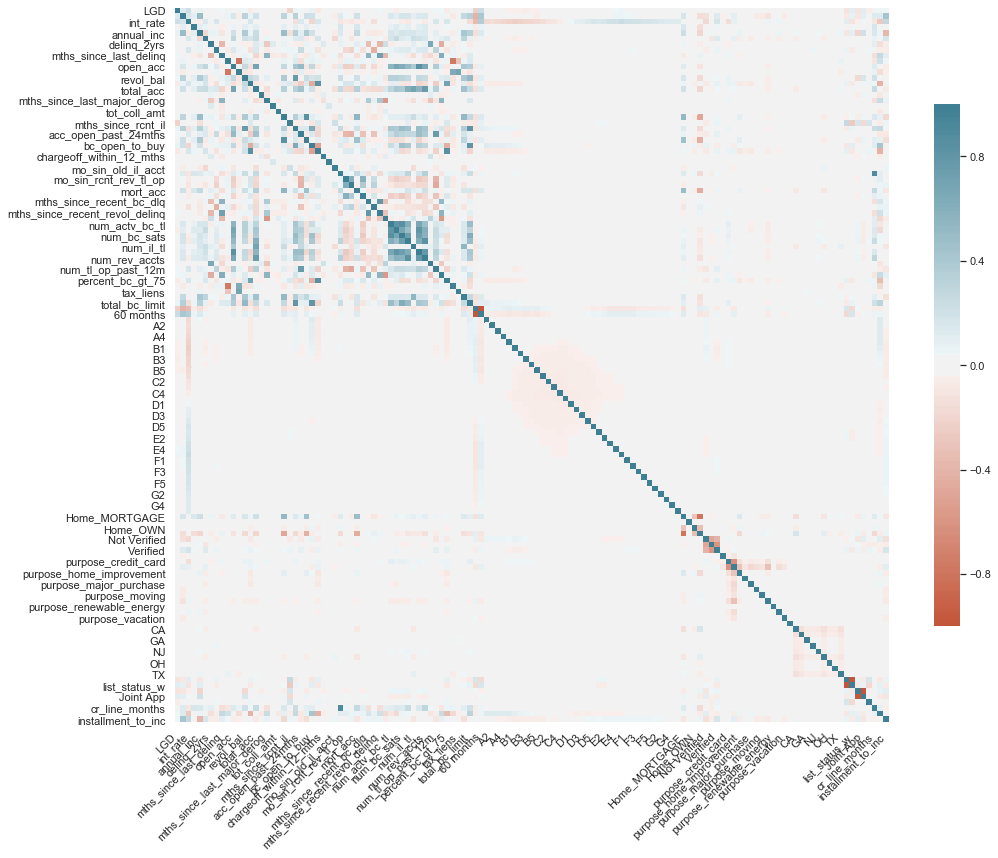

In [73]:
#Make a correlation heatmap

LGD = charged_off['LGD']
charged_off.drop(labels=['LGD'], axis=1,inplace = True)
charged_off.insert(0, 'LGD', LGD)

plt.figure(figsize=(16, 16))

corr = charged_off.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, cbar=True,cbar_kws={"shrink": .6}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [74]:
pd.set_option('display.max_rows',1000)
corr['LGD']

LGD                               1.000000
funded_amnt                       0.134159
int_rate                          0.224612
emp_length                       -0.036242
annual_inc                        0.070762
dti                               0.015404
delinq_2yrs                      -0.025741
inq_last_6mths                    0.029659
mths_since_last_delinq            0.042551
mths_since_last_record            0.032550
open_acc                         -0.008750
pub_rec                          -0.034109
revol_bal                         0.040100
revol_util                       -0.062510
total_acc                        -0.009040
collections_12_mths_ex_med        0.010798
mths_since_last_major_derog       0.029814
acc_now_delinq                   -0.008463
tot_coll_amt                     -0.007187
tot_cur_bal                       0.029493
mths_since_rcnt_il               -0.213653
total_rev_hi_lim                  0.050379
acc_open_past_24mths              0.040074
avg_cur_bal

In [75]:
#Random Forest Regression

target = ['LGD'] 
features = list(charged_off.drop(['LGD'],axis=1).columns)

#Scale features
charged_off[features] = scaler.fit_transform(charged_off[features])

#Create a Classifier
rfr=RandomForestRegressor(n_estimators=200, random_state = 42, 
                                max_depth = 10)

X = charged_off[features]
y = charged_off[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train.shape); print(X_test.shape)

rfr.fit(X_train, y_train)

print("Training Score:",rfr.score(X_train, y_train))

print("Test Score:",rfr.score(X_test, y_test))

y_true_rfr = y_test.LGD
y_pred_rfr = rfr.predict(X_test)

print("RMSE:",round(sqrt(mean_squared_error(y_true_rfr, y_pred_rfr)), 2))

(236989, 126)
(101567, 126)


C:\Users\armcl\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Training Score: 0.22465698462423
Test Score: 0.1905820513636971
RMSE: 0.2


No handles with labels found to put in legend.


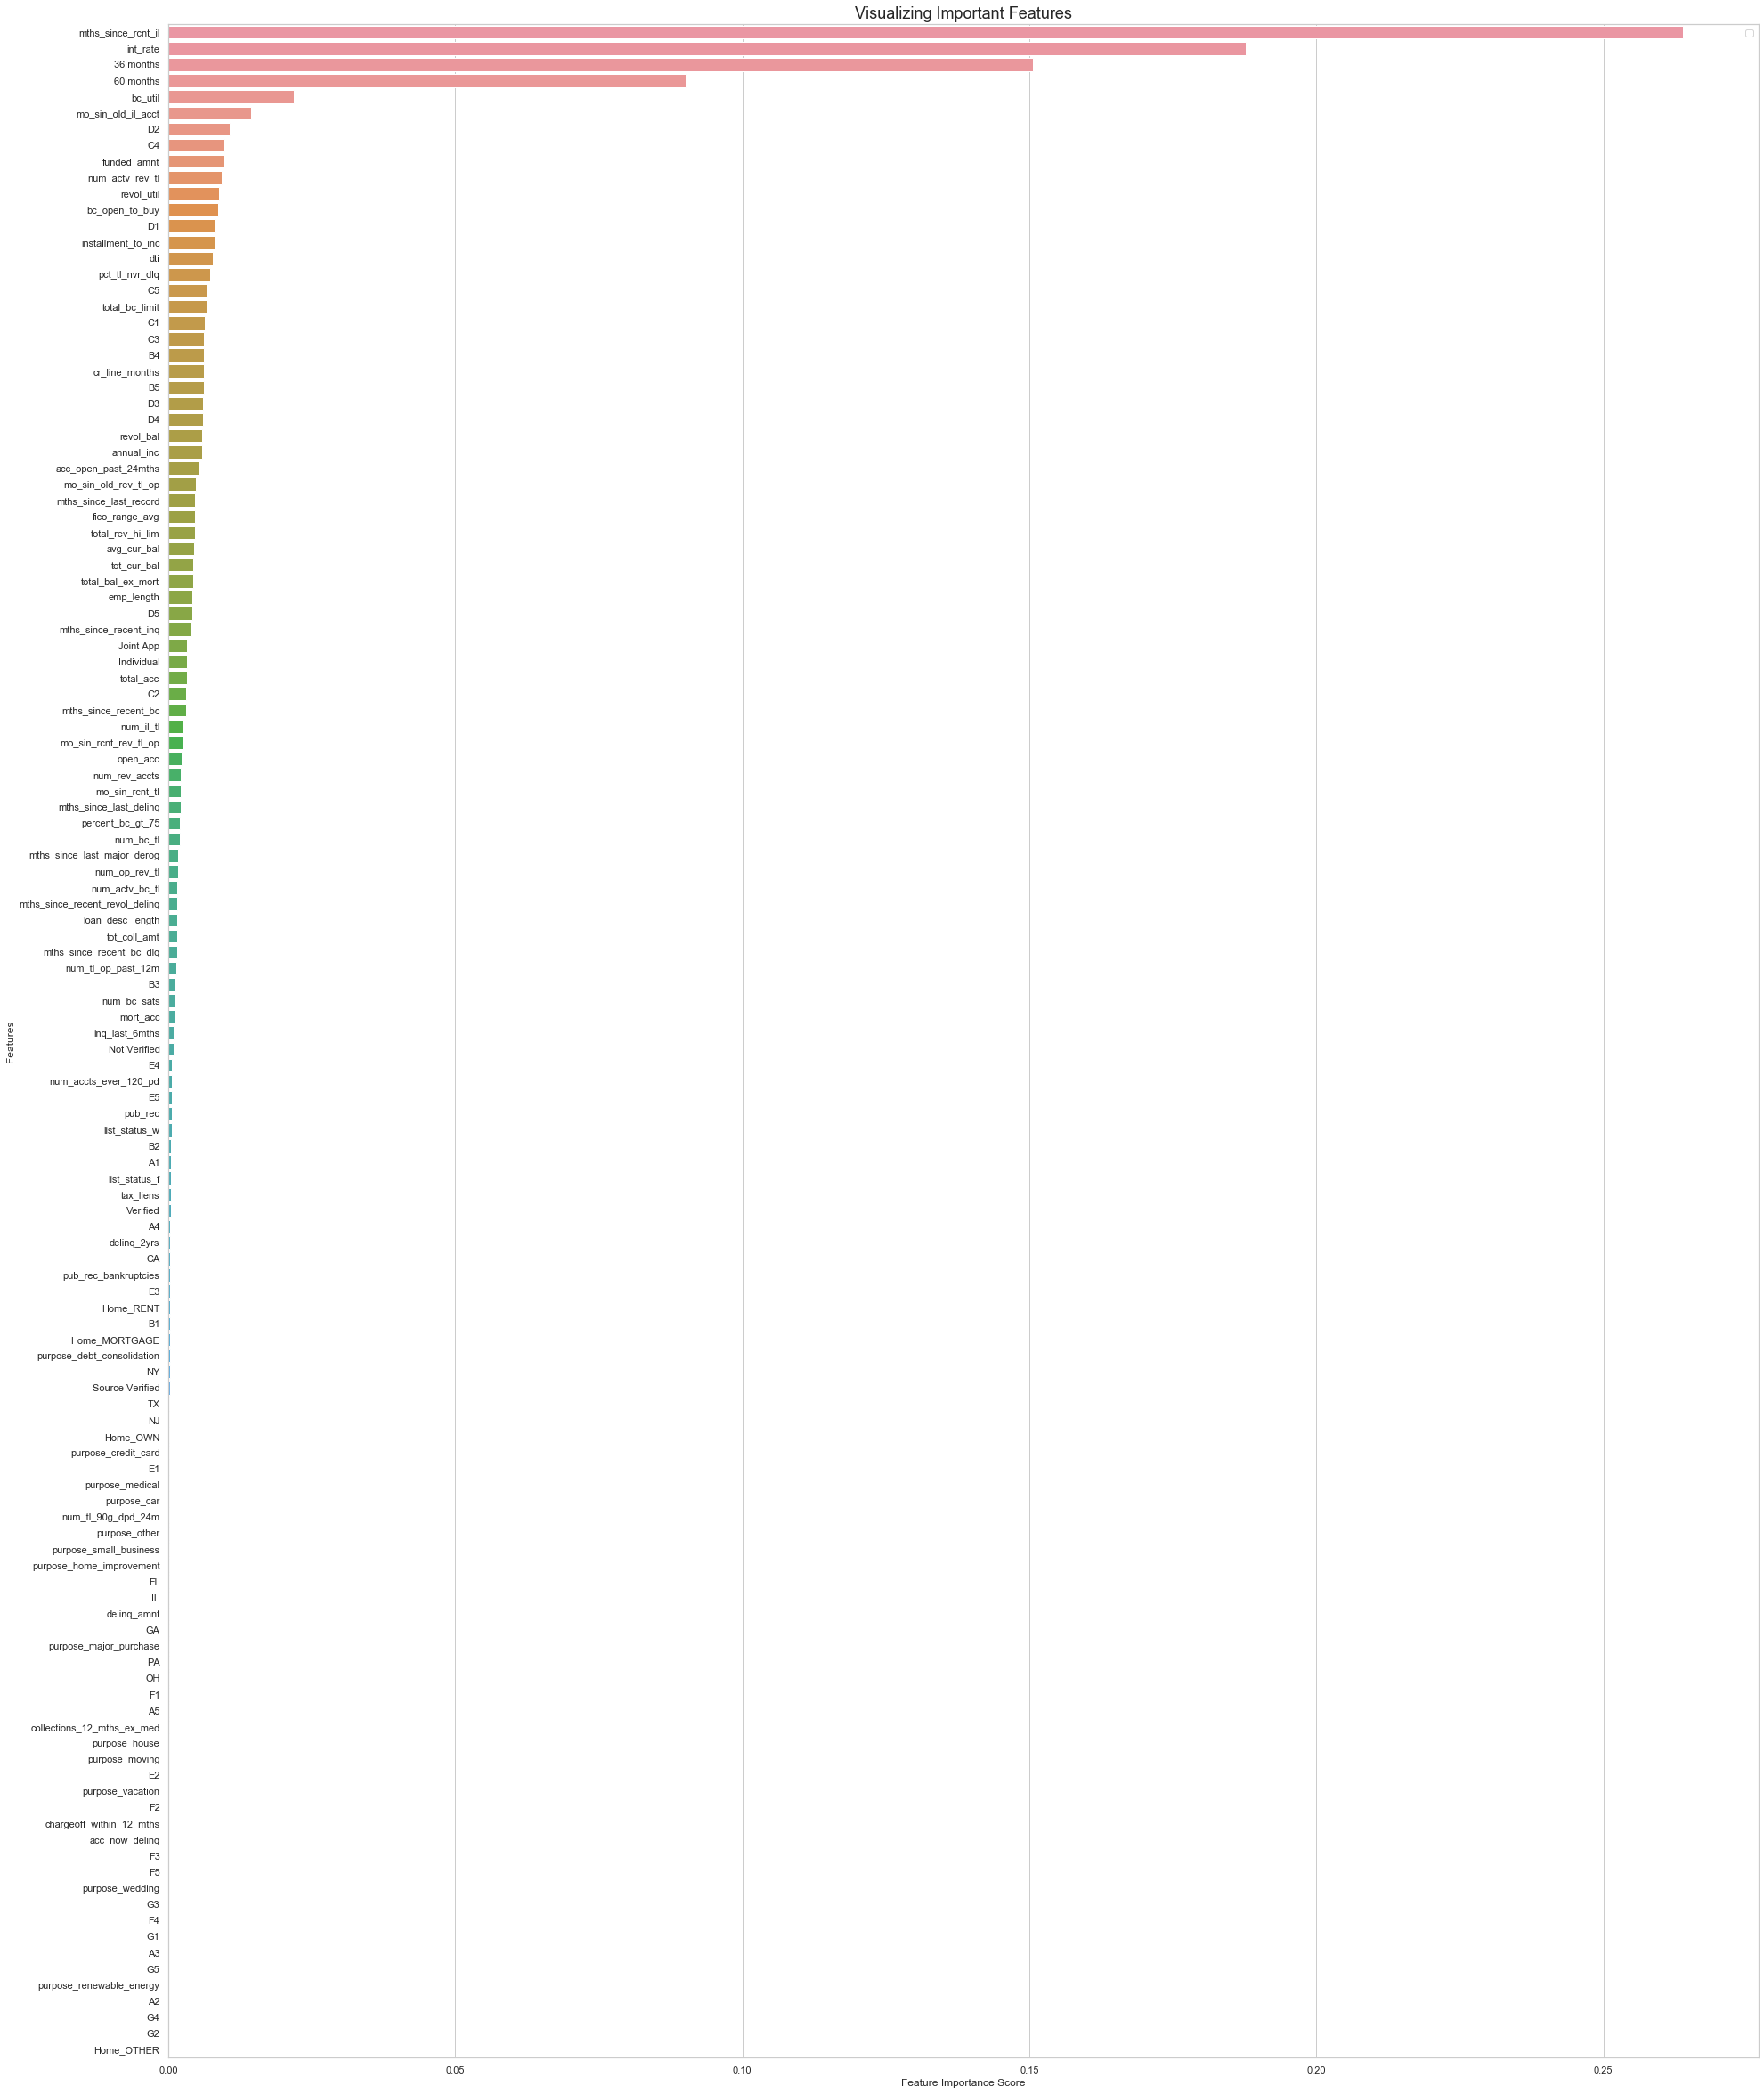

In [76]:
feature_imp = pd.Series(rfr.feature_importances_,index=features).sort_values(ascending=False)
plt.figure(figsize=(32, 42))
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", fontsize=18)
plt.legend()
plt.show()

In [77]:
#Try XGBOOST

target = ['LGD'] 
features = list(charged_off.drop(['LGD'],axis=1).columns)

X = charged_off[features]
y = charged_off[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train.shape); print(X_test.shape)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', max_depth = 3, n_estimators = 200)

xg_reg.fit(X_train,y_train)

y_pred_xg = xg_reg.predict(X_test)


(236989, 126)
(101567, 126)


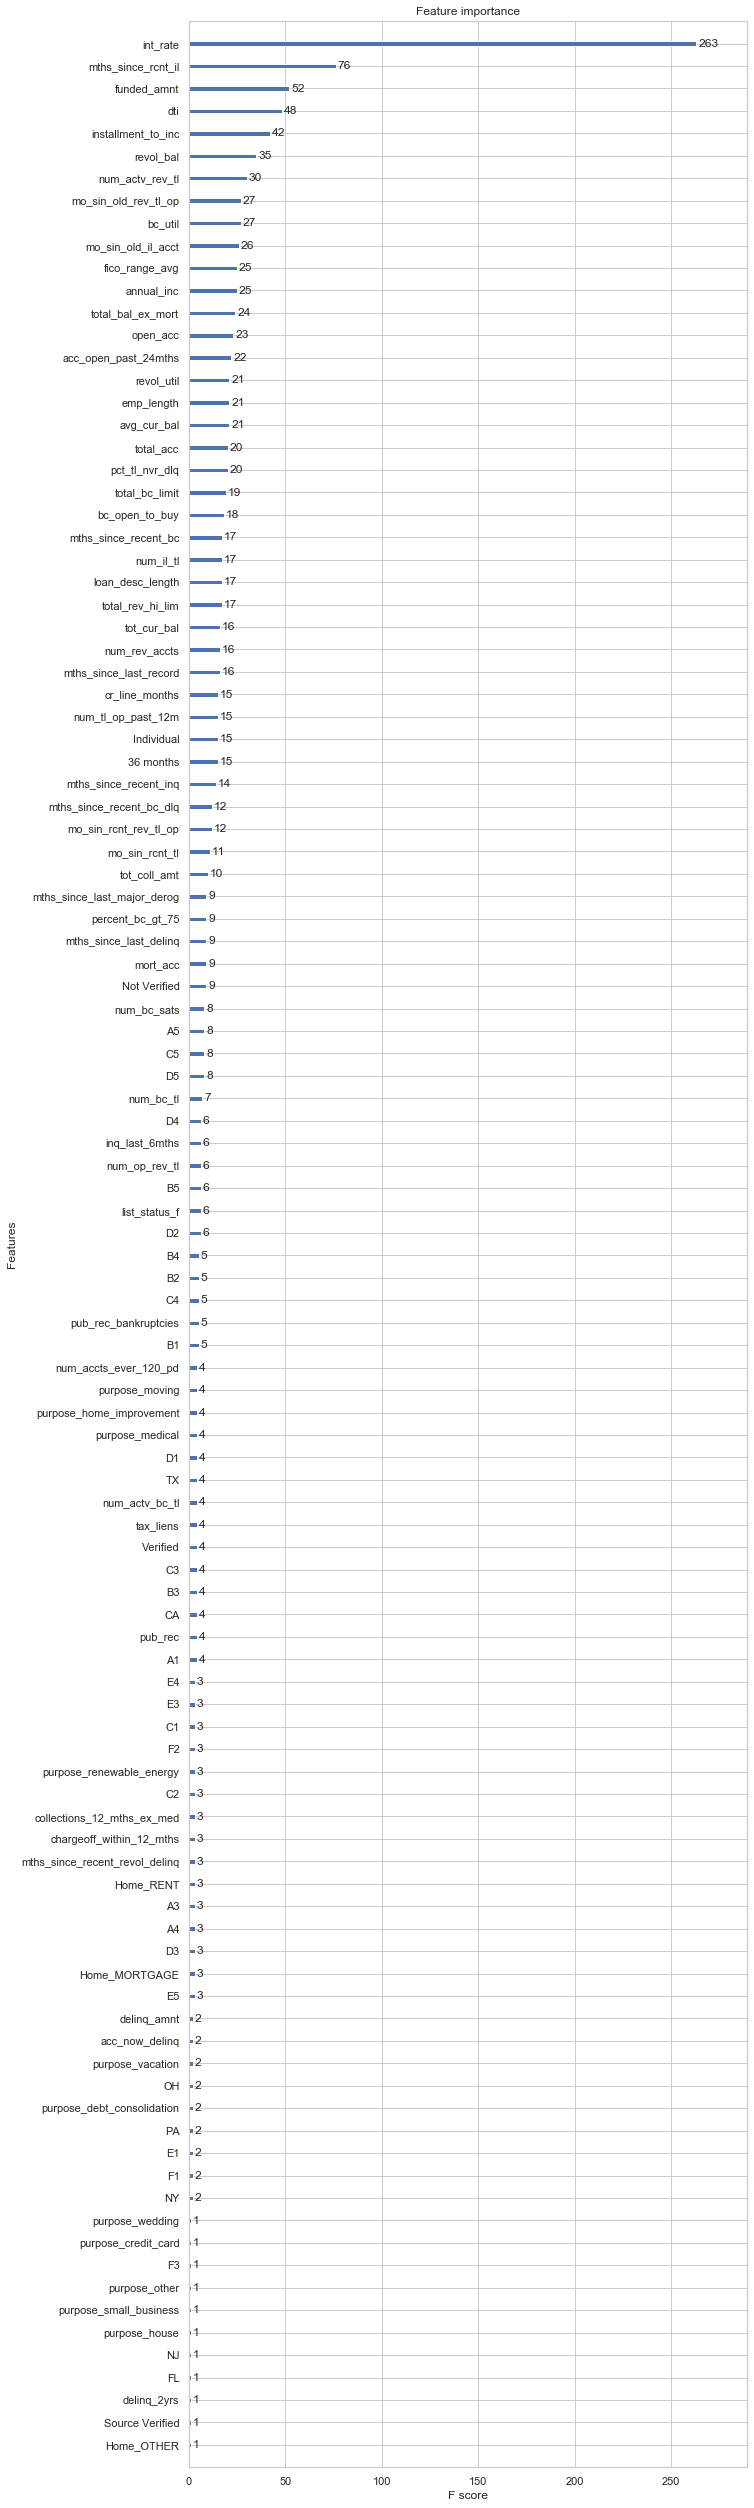

In [78]:
xgb.plot_importance(xg_reg)
#plt.rcParams['figure.figsize'] = [10,45]
plt.show()

In [79]:
print("XGBoost R^2:",xg_reg.score(X_test, y_test))
print("XGBoost RMSE:",round(np.sqrt(mean_squared_error(y_test, y_pred_xg)), 2))

XGBoost R^2: 0.2141215484354977
XGBoost RMSE: 0.2


In [80]:
charged_off.head(2)

,LGD,funded_amnt,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,mths_since_rcnt_il,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,36 months,60 months,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT,Not Verified,Source Verified,Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,CA,FL,GA,IL,NJ,NY,OH,PA,TX,list_status_f,list_status_w,Individual,Joint App,loan_desc_length,cr_line_months,fico_range_avg,installment_to_inc
42549,0.308887,1.299741,0.846931,-0.256970,0.020789,0.381630,0.704229,0.271657,-1.103849,0.483985,-0.335798,-0.376523,0.609185,1.235754,-0.025379,-0.145646,-1.735543,-0.065481,-0.133821,0.931474,1.131961,0.111031,-0.95145,0.991672,-0.274991,0.468783,7.915933,-0.018877,-0.034613,1.287255,-0.511028,-0.376424,1.525232,-0.595422,-1.925160,-0.274099,-1.525674,1.801453,0.494962,0.270132,0.052372,0.687835,-0.594569,-0.323676,0.218984,1.736781,-0.732872,-0.724126,0.909591,-0.388792,-0.128272,-0.255402,-0.000489,-1.225200,1.225200,-0.080056,-0.085553,-0.095786,-0.122197,-0.145503,-0.173604,-0.183332,-0.201351,-0.222229,-0.235872,-0.25604,-0.255863,-0.263407,-0.277087,-0.271886,-0.236408,-0.231443,-0.217802,-0.210424,5.067856,-0.171416,-0.164982,-0.158678,-0.148834,-0.14997,-0.117957,-0.102265,-0.093739,-0.085798,-0.079249,-0.069146,-0.057302,-0.051195,-0.046549,-0.044696,1.160887,-0.025091,-0.359624,-0.920909,-0.571538,1.194962,-0.719219,-0.086823,-0.488767,0.800912,-0.249626,-0.081483,-0.145905,-0.113234,-0.089511,-0.256583,-0.026355,-0.120934,-0.080967,-0.019524,-0.404117,-0.291131,-0.177546,-0.192307,-0.196359,-0.314077,-0.184268,-0.189799,-0.300017,1.398633,-1.398633,0.218308,-0.218308,20.795423,1.167492,-0.868281,0.738359
42552,0.403618,-0.873697,-0.937853,-0.984757,-0.990640,-0.476222,-0.370083,0.271657,1.020020,-1.588981,-0.511326,1.166075,-0.469901,-0.780677,-0.683219,-0.145646,0.646800,-0.065481,-0.133821,-0.774649,1.131961,-0.316165,-0.95145,-0.691761,-0.476415,0.390079,-0.091030,-0.018877,-0.163659,1.026677,0.155542,0.849446,-0.744143,-0.097567,0.577515,-0.274099,0.728903,-0.392632,-0.341622,-0.290860,-0.273718,-0.159031,-0.857186,-0.114076,-0.027780,-0.182992,-1.235043,0.674070,0.770457,2.075736,-0.128272,-0.745665,-0.577016,0.816193,-0.816193,-0.080056,-0.085553,-0.095786,-0.122197,-0.145503,-0.173604,5.454600,-0.201351,-0.222229,-0.235872,-0.25604,-0.255863,-0.263407,-0.277087,-0.271886,-0.236408,-0.231443,-0.217802,-0.210424,-0.197322,-0.171416,-0.164982,-0.158678,-0.148834,-0.14997,-0.117957,-0.102265,-0.093739,-0.085798,-0.079249,-0.069146,-0.057302,-0.051195,-0.046549,-0.044696,1.160887,-0.025091,-0.359624,-0.920909,1.749664,-0.836847,-0.719219,-0.086823,-0.488767,0.800912,-0.249626,-0.081483,-0.145905,-0.113234,-0.089511,-0.256583,-0.026355,-0.120934,-0.080967,-0.019524,-0.404117,-0.291131,-0.177546,-0.192307,-0.196359,-0.314077,-0.184268,-0.189799,-0.300017,1.398633,-1.398633,0.218308,-0.218308,-0.156189,0.890375,-0.116190,0.174372


In [81]:
#Linear Regression


#RFE Feature Selection
#Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model 
#and choose either the best or worst performing feature, setting the feature aside and then
#repeating the process with the rest of the features.

sub_grade_remove = list(charged_off.loc[:,'A2':'G4'].columns)
target = ['LGD'] 
features_lr = list(charged_off.drop(['LGD',' 60 months','Home_OTHER',
                                              'Source Verified','purpose_other','GA',
                                              'list_status_w','Joint App']+sub_grade_remove,axis=1).columns)

X = charged_off[features_lr]
y = charged_off[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train.shape); print(X_test.shape)

lr = LinearRegression(fit_intercept=True)
rfe = RFE(lr, 20)
rfe = rfe.fit(X_train, y_train)

print ("Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), features_lr)))


(236989, 86)
(101567, 86)


C:\Users\armcl\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Features sorted by their rank:
[(1, ' 36 months'), (1, 'Home_MORTGAGE'), (1, 'Home_OWN'), (1, 'Home_RENT'), (1, 'Individual'), (1, 'annual_inc'), (1, 'bc_util'), (1, 'emp_length'), (1, 'int_rate'), (1, 'list_status_f'), (1, 'mo_sin_old_il_acct'), (1, 'mths_since_last_delinq'), (1, 'mths_since_last_record'), (1, 'mths_since_rcnt_il'), (1, 'num_actv_rev_tl'), (1, 'num_bc_sats'), (1, 'num_bc_tl'), (1, 'num_rev_accts'), (1, 'pct_tl_nvr_dlq'), (1, 'total_bc_limit'), (2, 'open_acc'), (3, 'revol_util'), (4, 'num_op_rev_tl'), (5, 'acc_open_past_24mths'), (6, 'pub_rec_bankruptcies'), (7, 'CA'), (8, 'revol_bal'), (9, 'inq_last_6mths'), (10, 'mo_sin_rcnt_rev_tl_op'), (11, 'total_acc'), (12, 'total_bal_ex_mort'), (13, 'cr_line_months'), (14, 'dti'), (15, 'Not Verified'), (16, 'pub_rec'), (17, 'percent_bc_gt_75'), (18, 'tax_liens'), (19, 'funded_amnt'), (20, 'purpose_debt_consolidation'), (21, 'purpose_credit_card'), (22, 'mths_since_recent_inq'), (23, 'num_actv_bc_tl'), (24, 'TX'), (25, 'Verified'

In [82]:
#Top 30 features selected from RFE

features_sorted_by_rank = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), features_lr))
selected_features = [x[1] for x in features_sorted_by_rank[:30]]
selected_features

[' 36 months',
 'Home_MORTGAGE',
 'Home_OWN',
 'Home_RENT',
 'Individual',
 'annual_inc',
 'bc_util',
 'emp_length',
 'int_rate',
 'list_status_f',
 'mo_sin_old_il_acct',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'mths_since_rcnt_il',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_rev_accts',
 'pct_tl_nvr_dlq',
 'total_bc_limit',
 'open_acc',
 'revol_util',
 'num_op_rev_tl',
 'acc_open_past_24mths',
 'pub_rec_bankruptcies',
 'CA',
 'revol_bal',
 'inq_last_6mths',
 'mo_sin_rcnt_rev_tl_op',
 'total_acc']

In [83]:
features_lr2 = [x for x in selected_features if x not in ['tax_liens','num_op_rev_tl','num_rev_accts','pub_rec','total_acc','CA','num_bc_tl','num_bc_sats','Home_RENT','Home_OWN']]

X = charged_off[features_lr2]
y = charged_off[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


#Use p-value to find the significance of variables
ols_model=sm.OLS(y_train,X_train)

result=ols_model.fit()

print(result.summary2())

                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.020      
Dependent Variable:     LGD              AIC:                         440969.9503
Date:                   2020-05-08 01:16 BIC:                         441198.2172
No. Observations:       236989           Log-Likelihood:              -2.2046e+05
Df Model:               22               F-statistic:                 216.1      
Df Residuals:           236967           Prob (F-statistic):          0.00       
R-squared (uncentered): 0.020            Scale:                       0.37634    
-----------------------------------------------------------------------------------
                          Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
-----------------------------------------------------------------------------------
 36 months               -0.0399     0.0015   -27.0895   0.0000   -0.0428   -0.0370
Home_MORTGAGE            -0.0031 

In [84]:
lr = LinearRegression(fit_intercept=True)

lr.fit(X_train, y_train)

lr_test_score=lr.score(X_test,y_test)

#Return the R^2
print("LR test score:",lr_test_score)

y_pred_lr = lr.predict(X_test)

print("RMSE =", sqrt(mean_squared_error(y_test, y_pred_lr)))

LR test score: 0.15038273573439498
RMSE = 0.20836392825385347
